# HIGH VALUE CUSTOMER IDENTIFICATION

## SOLUTION PLANNING (IOT)

##### INPUT

Business Problems:
- Selecionar os clientes mais valiosos para integrar um programa de fidelização <b>"Diamond"</b>
- Vendas de um e-commerce online, durante o periodo de 1 ano (November 2015 to December 2017).

##### OUTPUT

1. Relatório com as respostas para as perguntas de negocio:


- Quem são as pessoas elegíveis para participar do programa <b>Diamond</b>?
- Quantos customers farão parte do programa?
- Quais as principais caracteristicas desses clientes?
- Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?
- Qual a expectativa de faturamento desse grupo para os proximos meses?
- Quais as condições para um cliente participar do programa?
- Quais as condições para um cliente ser removido do programa?
- Qual a garantia da eficacia do programa para o restante da base?
- Quais ações o squad de marketing pode realizar para aumentar o faturamento?

##### TASKS

1 - Quem são as pessoas elegíveis para participar do programa?
- O que é ser elegivel? O que são clientes de alto valor?
    - Faturamento:
        - Alto Ticket medio;
        - Alto LTV;
        - Baixa recencia;
        - Alto Basket size;
        - Baixa Probabilidade de Churn;
        - Alta previão LTV;
        - Alta propensão de compra.

- Custo:
    - Baixa taxa de devolução.

- Experiência de compra:
    - Média alta das avaliações

        

2 - Quantos customers farão parte do programa?

- Numero Total de clientes;
- (%) Percentual do grupo


3 - Quais as principais caracteristicas desses clientes?

- Caracteristicas unicas do cliente (Idade, Pais, Salário);
- Atributos da Clusterização.


4 - Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?

- Faturamento total da empresa durante o ano;
- Faturamento (%) apenas do cluster <b>Diamond</b>.



5 - Qual a expectativa de faturamento desse grupo para os proximos meses?

- LTV do grupo;
- Séries Temporais (ARMA, ARIMA, HoltWinter).

6 - Quais as condições para um cliente participar do programa?

- Definir prioridade (Sasonalidade - 1 mes, 3 meses);
- O desempenho do customer estar proximo da média do cluster <b>Diamond</b>.

7 - Quais as condições para um cliente ser removido do programa?

- Definir prioridade (Sasonalidade - 1 mes, 3 meses);
- O desempenho do customer não estar proximo da média do cluster <b>Diamond</b>.

8 - Qual a garantia da eficacia do programa para o restante da base?

- Teste A/B;
- Teste de hipóteses.

9 - Quais ações o squad de marketing pode realizar para aumentar o faturamento?

- Desconto;
- Preferencia de compra;
- Produtos exclusivos;
- Visita a empresa.


# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [112]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import plotly.express           as px
import seaborn                  as sns
import re
import inflection
import umap.umap_               as umap
from sklearn.cluster            import KMeans, DBSCAN
from sklearn.metrics            import silhouette_score
from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.decomposition      import PCA
from sklearn.manifold           import TSNE
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble           import RandomForestRegressor
from sklearn.mixture            import GaussianMixture
from scipy.cluster.hierarchy    import linkage, dendrogram, fcluster



## 1.2 - LOAD DATA

In [2]:
df_raw = pd.read_csv('../dataset/data.csv', encoding='latin-1')

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [3]:
sns.set(rc = {'figure.figsize':(13,5)})

### 1.3.2 - NA VOLUMETRY

In [4]:
def nan_volumetry(data):
    df_na = pd.DataFrame()
    df_na['attributes'] = data.columns
    df_na['volumetry'] = ''
    df_na['percentual'] = ''

    for i in df_na.index:
        volumetry = data[df_na.loc[i, 'attributes']].isna().sum()
        percentual = (volumetry / data['customer_id'].count()) * 100
        df_na.loc[i, 'volumetry'] = volumetry
        df_na.loc[i, 'percentual'] = f"{percentual:.2f}%"  

    return df_na

# 2.0 - DATA DESCRIPTION

In [5]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSION

In [6]:
print('Total of unique features:\n')
print(df2.apply(lambda x: x.nunique()))
print('\nNumber of rows: {}'.format(df2.shape[0]))
print('Number of cols: {}'.format(df2.shape[1]))

Total of unique features:

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Number of rows: 541909
Number of cols: 8


## 2.2 - RENAME COLUMNS

In [7]:
old_columns = df2.columns
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))
df2.columns = new_columns

## 2.3 - DATA TYPES

In [8]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 - NAN VOLUMETRY

In [9]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [10]:
nan_volumetry(df2)

,attributes,volumetry,percentual
0,invoice_no,0,0.00%
1,stock_code,0,0.00%
2,description,1454,0.36%
3,quantity,0,0.00%
4,invoice_date,0,0.00%
5,unit_price,0,0.00%
6,customer_id,135080,33.20%
7,country,0,0.00%


### 2.4.1 - FILL NA

In [11]:
df_missing = df2.loc[df2['customer_id'].isna(),:]
df_full = df2.loc[~df2['customer_id'].isna(),:]

In [12]:
#Create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(1900, 1900 + len(df_backup), 1)

#merge original with reference dataframe

df2 = pd.merge(df2, df_backup, on = 'invoice_no', how = 'left')
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id_x,country,customer_id_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,NaN


In [13]:
#coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])

#drop extra columns
df2 = df2.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,17850.0


In [14]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 2.5 - CHANGE DATA TYPES

In [15]:
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])
df2['customer_id'] = df2['customer_id'].astype(int)

In [16]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

# 3.0 - DESCRIPTIVE STATISTICS

In [17]:
df3 = df2.copy()
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df3.select_dtypes(include = 'object')

## 3.1 - NUMERICAL ATTRIBUTES

In [18]:
#central tendency: median - mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion: max, min, std, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.max)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.std)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
df_concat = pd.concat([d2, d1, d4, ct1, ct2, d3, d5, d6]).T.reset_index()
df_concat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_concat


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,1900.00,18287.0,16387.00,12426.375722,14382.00,5217.395870,-0.930929,-0.694653


### 3.1.1 - NUMERICAL ATTRIBUTES ANALYSIS

- Negative Quantity (Returning products?)
- Unity Price less than zero (Product discount?)

## 3.2 - CATEGORICAL ATTRIBUTES

In [19]:
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'country'], dtype='object')

### INVOICE NUMBER

We have Invoice Number with letters and numbers, sendo assim iremos padronizar para uma variavel numerica pois se trata de uma ordem de compra.

In [20]:
invoice_letters = df3.loc[df3['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
invoice_letters

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom,17548
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,United Kingdom,14397
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,United Kingdom,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,United Kingdom,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,United Kingdom,17315


Observando que a coluna Quantity indicam numeros negativos, podemos assumir que são dados relacionados a descontos, devolução ou estorno (cancelamento) de mercadorias pois correspondem a quantidade total de ordens com letras.

In [21]:
print('Total records with almost an letter is: {}'.format(len(invoice_letters)))
print('Total of records with negative quantity is: {}'.format(len(invoice_letters.loc[invoice_letters['quantity'] < 0])))

Total records with almost an letter is: 9291
Total of records with negative quantity is: 9288


STOCK CODE

Analise de stocke code com apenas caracteres

In [22]:
df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
411948,572241,POST,POSTAGE,1,2011-10-21 15:20:00,18.00,Germany,12712
117253,546374,M,Manual,1,2011-03-11 12:05:00,10.00,United Kingdom,17194
396346,571061,DOT,DOTCOM POSTAGE,1,2011-10-13 14:33:00,852.25,United Kingdom,4923
457887,575750,POST,POSTAGE,3,2011-11-11 10:29:00,18.00,Germany,12600
515874,579790,POST,POSTAGE,2,2011-11-30 15:38:00,28.00,Portugal,12784
373859,569364,M,Manual,12,2011-10-03 15:10:00,1.00,United Kingdom,13167
261431,559862,POST,POSTAGE,4,2011-07-13 10:30:00,28.00,Portugal,12782
492555,578126,POST,POSTAGE,1,2011-11-23 10:32:00,4.95,United Kingdom,16900
183724,552667,DOT,DOTCOM POSTAGE,1,2011-05-10 15:05:00,118.38,United Kingdom,3489
242566,C558357,M,Manual,-2,2011-06-28 15:04:00,3.56,United Kingdom,15502


In [23]:
stock_code_letters = df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
stock_code_letters

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### DESCRIPTION

We'll drop the Description column, because its not usefull or bring some insight ou metric to our analysis.

In [24]:
df3.sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
279200,561246,21878,PACK OF 6 SANDCASTLE FLAGS ASSORTED,12,2011-07-26 11:38:00,0.85,United Kingdom,16951
198518,554054,22027,TEA PARTY BIRTHDAY CARD,2,2011-05-20 15:29:00,0.83,United Kingdom,3600
189497,553156,22149,FELTCRAFT 6 FLOWER FRIENDS,1,2011-05-13 14:58:00,2.10,United Kingdom,17841
59340,541282,84692,BOX OF 24 COCKTAIL PARASOLS,25,2011-01-17 12:31:00,0.42,United Kingdom,17690
416333,572552,22810,SET OF 6 T-LIGHTS SNOWMEN,6,2011-10-24 17:07:00,5.79,United Kingdom,14096


### COUNTRY

In [25]:
print('Total of unique Countries: {}'.format(df3['country'].unique()))
print('\n Total of number of unique Countries: {}'.format(df3['country'].nunique()))
print('\n Percentual of orders per country:')
(df3['country'].value_counts(normalize = True)*100).apply(lambda x: '{:.2f}%'.format(x))

Total of unique Countries: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']

 Total of number of unique Countries: 38

 Percentual of orders per country:


country
United Kingdom          91.43%
Germany                  1.75%
France                   1.58%
EIRE                     1.51%
Spain                    0.47%
Netherlands              0.44%
Belgium                  0.38%
Switzerland              0.37%
Portugal                 0.28%
Australia                0.23%
Norway                   0.20%
Italy                    0.15%
Channel Islands          0.14%
Finland                  0.13%
Cyprus                   0.11%
Sweden                   0.09%
Unspecified              0.08%
Austria                  0.07%
Denmark                  0.07%
Japan                    0.07%
Poland                   0.06%
Israel                   0.05%
USA                      0.05%
Hong Kong                0.05%
Singapore                0.04%
Iceland                  0.03%
Canada                   0.03%
Greece                   0.03%
Malta                    0.02%
United Arab Emirates     0.01%
European Community       0.01%
RSA                      0.01%


Quantity of Customers by Country

In [26]:
df3[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 4.0 - FEATURE SELECTION

In [27]:
df4 = df3.copy()

## 4.1 - NUMERICAL ATTRIBUTES

Identificar os valores unicos dentro do unit price para seguimentar os records.

In [28]:
df4[['customer_id', 'description','unit_price']].sort_values('unit_price', ascending = True).drop_duplicates(subset='unit_price').head(10)

,customer_id,description,unit_price
299984,4399,Adjust bad debt,-11062.060
40984,2196,TRAVEL SEWING KIT,0.000
157195,13952,PADS TO MATCH ALL CUSHIONS,0.001
108088,16422,Discount,0.010
182729,12901,Discount,0.030
326771,17612,POPART WOODEN PENCILS ASST,0.040
530198,17884,LETTER SHAPE PENCIL SHARPENER,0.060
210605,14298,PAPER POCKET TRAVELING FAN,0.070
258193,13678,PIECE OF CAMO STATIONERY SET,0.080
524404,13126,ASS DES PHONE SPONGE CRAFT STICKER,0.090


In [29]:
df4 = df4.loc[df4['unit_price'] >= 0.04]

## 4.2 - CATEGORICAL ATTRIBUTES

Deletar a coluna Description pois não agrega informações uteis de insights ou como feature para o treinamento do modelo de clusterização nesse ciclo de desenvolvimento

In [30]:
df4 = df4.drop(columns = 'description', axis = 1)

Deletar os registros que possuem o vetor ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

In [31]:
df4 = df4.loc[~df4['stock_code'].isin(stock_code_letters)]

Deletar os registros da feature Country os valores que contem 'Unspecified' e 'European Community'.<br>
- Unspecified: Conjunto de Paises não especificados;
- European Community: Conjunto de Paises não especificados dentro da Europa.

In [32]:
df4 = df4.loc[~df4['country'].isin(['Unspecified','European Community'])]

## 4.3 - DATASET SEGMENTATION

Vamos seguimentar o dataset entre orders Returns e Purchase.<br>
Essa estratégia consiste em calcularmos a Recency, Frequency and Monetary (RFM) sem o peso ou influencia de dados de ordens estornadas ou canceladas

In [33]:
df_returns = df4.loc[df4['quantity'] < 0]
df_purchase = df4.loc[df4['quantity'] >= 0]

# 5.0 - FEATURE ENGINEERING

In [34]:
df5 = df4.copy()

In [35]:
df_reference = df5['customer_id'].drop_duplicates(ignore_index = True)

## 5.1 - GROSS REVENUE

In [36]:
#gross Revenue (quantity * price)
df_purchase = df_purchase.copy()
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


#monetary
df_monetary = df_purchase.loc[:,['customer_id','gross_revenue']].groupby('customer_id')['gross_revenue'].sum().reset_index()
df_reference = pd.merge(df_reference, df_monetary, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

## 5.2 - RECENCY - DAY FROM LAST PURCHASE

In [37]:
#recency (Last Day Purchase)
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id')['invoice_date'].max().reset_index()
recency_days = (df5['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency['recency_days'] = recency_days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_reference = pd.merge(df_reference, df_recency, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## 5.3 - QUANTITY OF PURCHASED

In [38]:
#frequency (Quantity of Purchase)
df_frequency = df_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'quantity_invoices'})
df_reference = pd.merge(df_reference, df_frequency, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
dtype: int64

## 5.4 - QUANTITY OF ITEMS PURCHASED

In [39]:
#frequency (Quantity of Purchase)
df_frequency = df_purchase[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'quantity_items'})
df_reference = pd.merge(df_reference, df_frequency, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
dtype: int64

## 5.5 - QUANTITY OF PRODUCTS PURCHASED

In [40]:

df_frequency = df_purchase[['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'quantity_stock_code'})
df_reference = pd.merge(df_reference, df_frequency, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_stock_code    91
dtype: int64

## 5.6 - AVERAGE TICKET VALUE

In [41]:
#average ticket
df_ticket = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue': 'avg_ticket'})
df_reference = pd.merge(df_reference, df_ticket, on =  'customer_id', how = 'left')
df_reference.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_stock_code    91
avg_ticket             91
dtype: int64

## 5.7 - AVERAGE RECENCY DAYS

In [42]:
df_aux = df5[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=False)
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #nest customer
df_aux['previus_date'] = df_aux['invoice_date'].shift() #next invoice date  

df_aux['avg_recency_days'] = df_aux.apply(lambda x: -1*(x['invoice_date'] - x['previus_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previus_date'], axis = 1).dropna()

#average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

df_reference = pd.merge(df_reference, df_avg_recency_days, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
quantity_invoices        91
quantity_items           91
quantity_stock_code      91
avg_ticket               91
avg_recency_days       2744
dtype: int64

## 5.8 - FREQUENCY PURCHASE

In [43]:
df5_max = df5[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df5_min = df5[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df_purchase = df5[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

In [44]:
purchase = df5.loc[df5['quantity'] >= 0]
df_aux = purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
    max_ = ('invoice_date', 'max'), 
    min_ = ('invoice_date', 'min'), 
    days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) +1 ),
    buy_ = ('invoice_no', 'count')).reset_index()

#frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)
#df_aux.head()
df_reference = pd.merge(df_reference, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
quantity_invoices        91
quantity_items           91
quantity_stock_code      91
avg_ticket               91
avg_recency_days       2744
frequency                91
dtype: int64

## 5.9 - NUMBER OF RETURNS

In [45]:
df_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity':'returns'})
df_returns['returns'] = df_returns['returns'] * -1
df_returns.head()

,customer_id,returns
0,1971,103
1,1999,1
2,2107,1
3,2110,1
4,2199,1


In [46]:
df_reference = pd.merge(df_reference, df_returns, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
quantity_invoices        91
quantity_items           91
quantity_stock_code      91
avg_ticket               91
avg_recency_days       2744
frequency                91
returns                4191
dtype: int64

In [47]:
# Fill NAN of return
df_reference.loc[df_reference['returns'].isna(), 'returns'] = 0
df_reference.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
quantity_invoices        91
quantity_items           91
quantity_stock_code      91
avg_ticket               91
avg_recency_days       2744
frequency                91
returns                   0
dtype: int64

## 5.10 - BASKET SIZE

In [48]:
purchase = df5.loc[df5['quantity'] >= 0]
df_aux = purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(
        n_purchase = ('invoice_no', 'nunique'), 
        n_products = ('stock_code', 'count')).reset_index()

#calculate
df_aux['avg_unique_basket_size'] = np.round(df_aux['n_products'] / df_aux['n_purchase'], 2)

df_aux.sample(10)

,customer_id,n_purchase,n_products,avg_unique_basket_size
2940,14496,2,19,9.50
3326,15038,6,130,21.67
1067,4587,1,188,188.00
3301,15006,1,143,143.00
5416,17899,1,32,32.00
4763,16987,7,129,18.43
4941,17244,1,31,31.00
5074,17431,1,43,43.00
4203,16214,3,44,14.67
2175,13430,2,49,24.50


In [49]:
df_reference = pd.merge(df_reference, df_aux[['customer_id', 'avg_unique_basket_size']], on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
quantity_invoices           91
quantity_items              91
quantity_stock_code         91
avg_ticket                  91
avg_recency_days          2744
frequency                   91
returns                      0
avg_unique_basket_size      91
dtype: int64

## 5.11 - UNIQUE ITENS BASKET SIZE

In [50]:
purchase = df5.loc[df5['quantity'] >= 0]
df_aux = purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(
        n_purchase = ('invoice_no', 'nunique'), 
        n_products = ('quantity', 'sum')).reset_index()

df_aux['avg_basket_size'] = np.round(df_aux['n_products'] / df_aux['n_purchase'], 2)

df_aux.sample(10)

,customer_id,n_purchase,n_products,avg_basket_size
5634,18204,3,1200,400.00
5227,17644,11,1793,163.00
201,2315,1,893,893.00
5027,17372,8,749,93.62
5053,17405,3,726,242.00
4793,17034,3,410,136.67
1195,5057,1,559,559.00
3630,15436,3,613,204.33
118,2174,1,25,25.00
3986,15919,2,545,272.50


In [51]:
df_reference = pd.merge(df_reference, df_aux[['customer_id', 'avg_basket_size']], on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
quantity_invoices           91
quantity_items              91
quantity_stock_code         91
avg_ticket                  91
avg_recency_days          2744
frequency                   91
returns                      0
avg_unique_basket_size      91
avg_basket_size             91
dtype: int64

## 5.12 - CLEANING NA

In [52]:
df_reference = df_reference.dropna()
df_reference.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
quantity_invoices         0
quantity_items            0
quantity_stock_code       0
avg_ticket                0
avg_recency_days          0
frequency                 0
returns                   0
avg_unique_basket_size    0
avg_basket_size           0
dtype: int64

# 6.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [53]:
df6 = df_reference.copy()

## 6.1 - UNIVARIATE ANALYSIS

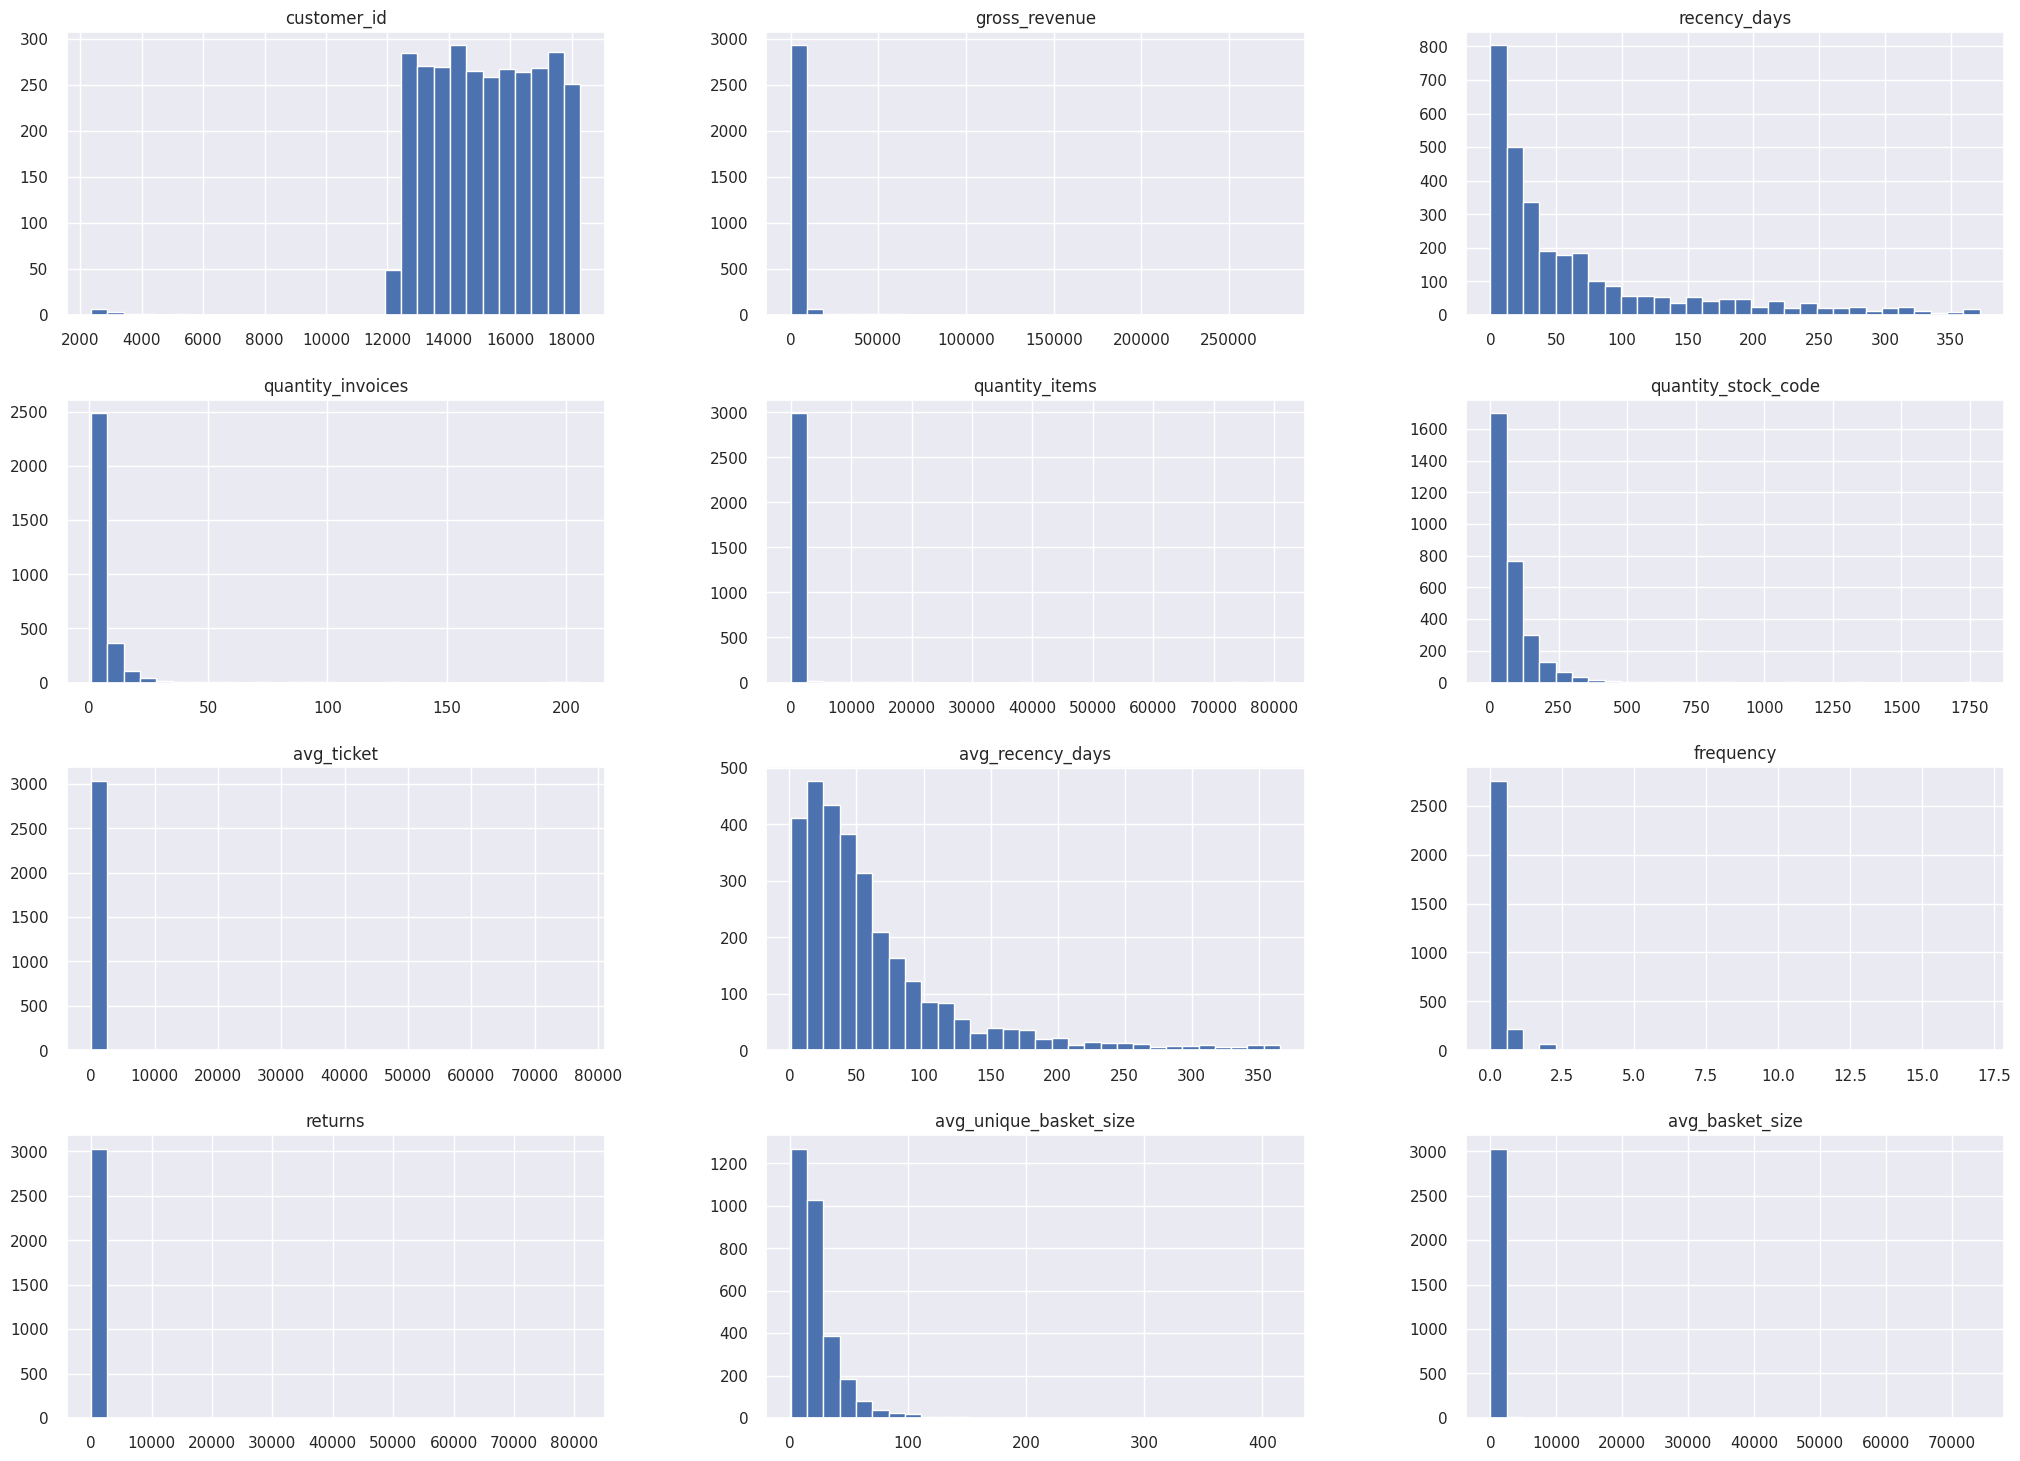

In [54]:
df6.hist(figsize=(25, 18), bins=30)
plt.show()

### GROSS REVENUE

In [55]:
print('Max: {}'.format(df6['gross_revenue'].max()))
print('Min: {}'.format(df6['gross_revenue'].min()))
print('Mean: {}'.format(np.around(df6['gross_revenue'].mean(), 2)))
print('Median: {}'.format(np.around(df6['gross_revenue'].median(), 2)))
print('Standart Deviation: {}'.format(np.around(df6['gross_revenue'].std(), 2)))
print('Coefficient of variation: {}'.format((df6['gross_revenue'].mean() / df6['gross_revenue'].std())*100))

Max: 279138.02
Min: 6.2
Mean: 2749.08
Median: 1067.49
Standart Deviation: 10576.89
Coefficient of variation: 25.99138034996947


In [56]:
df6[['customer_id','gross_revenue']].sort_values('gross_revenue',ascending = False).head(10)

,customer_id,gross_revenue
1017,14646,279138.02
492,18102,259657.30
433,17450,194550.79
3338,16446,168472.50
66,14911,140450.72
1150,12415,124564.53
190,14156,117379.63
15,17511,91062.38
1381,12346,77183.60
12,16029,72882.09


In [57]:
df6[df6['customer_id'] == 14646].T

,1017
customer_id,14646.000000
gross_revenue,279138.020000
recency_days,1.000000
quantity_invoices,72.000000
quantity_items,15837.000000
quantity_stock_code,699.000000
avg_ticket,135.503893
avg_recency_days,5.555556
frequency,0.203390
returns,288.000000


### RECENCY DAYS

In [58]:
print('Max: {}'.format(df6['recency_days'].max()))
print('Min: {}'.format(df6['recency_days'].min()))
print('Mean: {}'.format(df6['recency_days'].mean()))
print('Median: {}'.format(df6['recency_days'].median()))
print('Standart Deviation: {}'.format(df6['recency_days'].std()))
print('Coefficient of variation: {}'.format((df6['recency_days'].mean() / df6['recency_days'].std())*100))

Max: 372.0
Min: 0.0
Mean: 65.91809210526316
Median: 32.0
Standart Deviation: 79.95689157093021
Coefficient of variation: 82.44203946671294


In [59]:
df6[['customer_id','recency_days']].sort_values('recency_days',ascending = False).head(10)

,customer_id,recency_days
63,15922,372.0
140,15363,372.0
82,16048,372.0
0,17850,371.0
223,13370,371.0
168,15823,371.0
160,16781,371.0
293,14813,369.0
352,16858,368.0
312,15880,368.0


### QUANTITY OF INVOICES

In [60]:
print('Max: {}'.format(df6['quantity_invoices'].max()))
print('Min: {}'.format(df6['quantity_invoices'].min()))
print('Mean: {}'.format(np.around(df6['quantity_invoices'].mean(), 2)))
print('Median: {}'.format(np.around(df6['quantity_invoices'].median(), 2)))
print('Standart Deviation: {}'.format(np.around(df6['quantity_invoices'].std(), 2)))
print('Coefficient of variation: {}'.format((df6['quantity_invoices'].mean() / df6['quantity_invoices'].std())*100))

Max: 206.0
Min: 1.0
Mean: 5.63
Median: 3.0
Standart Deviation: 8.77
Coefficient of variation: 64.15350419538976


In [61]:
df6[['customer_id','quantity_invoices']].sort_values('quantity_invoices',ascending = False).head(10)

,customer_id,quantity_invoices
47,12748,206.0
66,14911,199.0
68,17841,124.0
278,13089,97.0
96,14606,91.0
8,15311,91.0
183,12971,86.0
1017,14646,72.0
12,16029,62.0
19,13408,62.0


### QUANTITY OF ITEMS

In [62]:
print('Max: {}'.format(df6['quantity_items'].max()))
print('Min: {}'.format(df6['quantity_items'].min()))
print('Mean: {}'.format(np.around(df6['quantity_items'].mean(), 2)))
print('Median: {}'.format(np.around(df6['quantity_items'].median(), 2)))
print('Standart Deviation: {}'.format(np.around(df6['quantity_items'].std(), 2)))
print('Coefficient of variation: {}'.format((df6['quantity_items'].mean() / df6['quantity_items'].std())*100))

Max: 80996.0
Min: 1.0
Mean: 404.86
Median: 152.0
Standart Deviation: 2341.67
Coefficient of variation: 17.28934110945664


In [63]:
df6[['customer_id','quantity_items']].sort_values('quantity_items',ascending = False).head(10)

,customer_id,quantity_items
3338,16446,80996.0
1381,12346,74215.0
433,17450,38639.0
1705,16333,21352.0
249,17949,17376.0
2345,12901,17150.0
970,12931,16288.0
1017,14646,15837.0
36,13694,13369.0
492,18102,12872.0


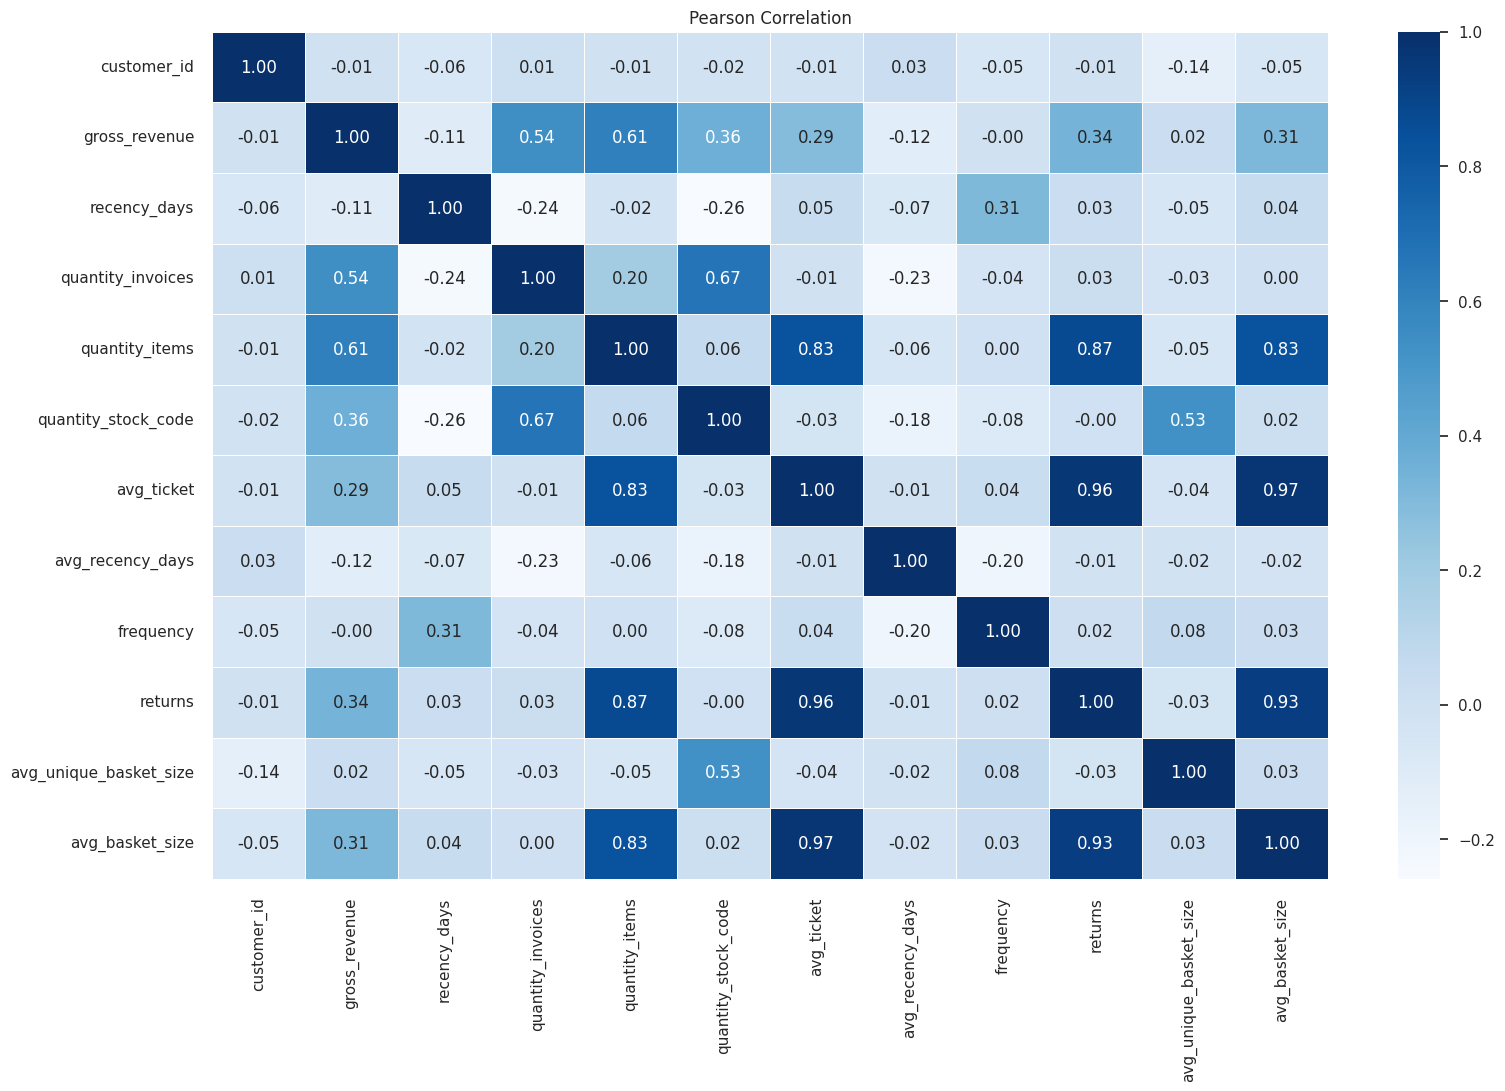

In [64]:
correlation_matrix = df6.corr('pearson')

plt.figure(figsize=(18, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation')
plt.show()


### 6.1.13 - FEATURE ADJUSTMENT

In [65]:
df6 = df6[~df6['customer_id'].isin([16446])]

## 6.2 - SPACE STUDY ANALYSIS

In [66]:
df_space = df6.drop(columns = 'customer_id', axis = 1).copy()
df_space.columns

Index(['gross_revenue', 'recency_days', 'quantity_invoices', 'quantity_items',
       'quantity_stock_code', 'avg_ticket', 'avg_recency_days', 'frequency',
       'returns', 'avg_unique_basket_size', 'avg_basket_size'],
      dtype='object')

In [67]:
mms = MinMaxScaler()

df_space['gross_revenue']          = mms.fit_transform(df_space[['gross_revenue']])
df_space['recency_days']           = mms.fit_transform(df_space[['recency_days']])
df_space['quantity_invoices']      = mms.fit_transform(df_space[['quantity_invoices']])
df_space['quantity_items']         = mms.fit_transform(df_space[['quantity_items']])
df_space['quantity_stock_code']    = mms.fit_transform(df_space[['quantity_stock_code']])
df_space['avg_ticket']             = mms.fit_transform(df_space[['avg_ticket']])
df_space['avg_recency_days']       = mms.fit_transform(df_space[['avg_recency_days']])
df_space['frequency']              = mms.fit_transform(df_space[['frequency']])
df_space['returns']                = mms.fit_transform(df_space[['returns']])
df_space['avg_unique_basket_size'] = mms.fit_transform(df_space[['avg_unique_basket_size']])
df_space['avg_basket_size']        = mms.fit_transform(df_space[['avg_basket_size']])



### 6.2.1 - PCA ANALYSIS

In [68]:
df_space.shape[1]

11

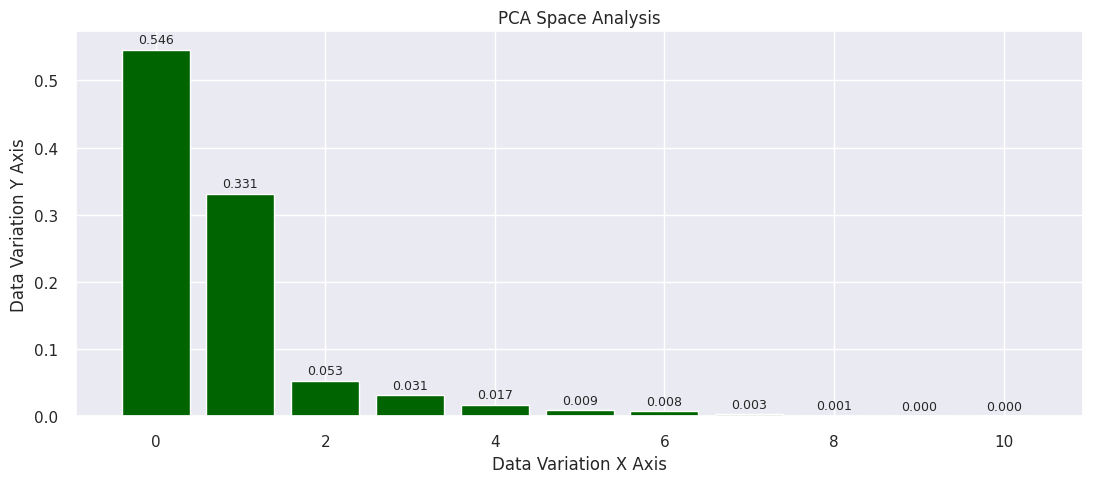

In [69]:
pca = PCA(n_components = df_space.shape[1])

principal_components = pca.fit_transform(df_space)

#plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.title('PCA Space Analysis')
plt.xlabel('Data Variation X Axis')
plt.ylabel('Data Variation Y Axis')

for i, explained_var in enumerate(pca.explained_variance_ratio_):
    plt.text(i, explained_var + 0.005, f'{explained_var:.3f}', ha='center', va='bottom', fontsize=9)

plt.show()

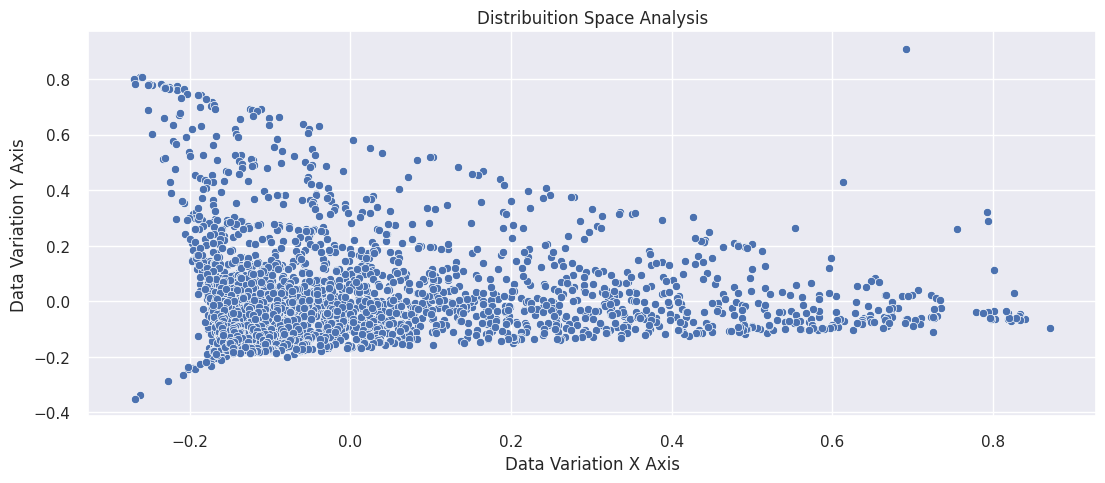

In [70]:
df_pca = pd.DataFrame(principal_components)
sns.scatterplot(df_pca, x = 0, y = 1,)
plt.title('Distribuition Space Analysis')
plt.xlabel('Data Variation X Axis')
plt.ylabel('Data Variation Y Axis')
plt.show()

### 6.2.2 - UMAP ANALYSIS

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


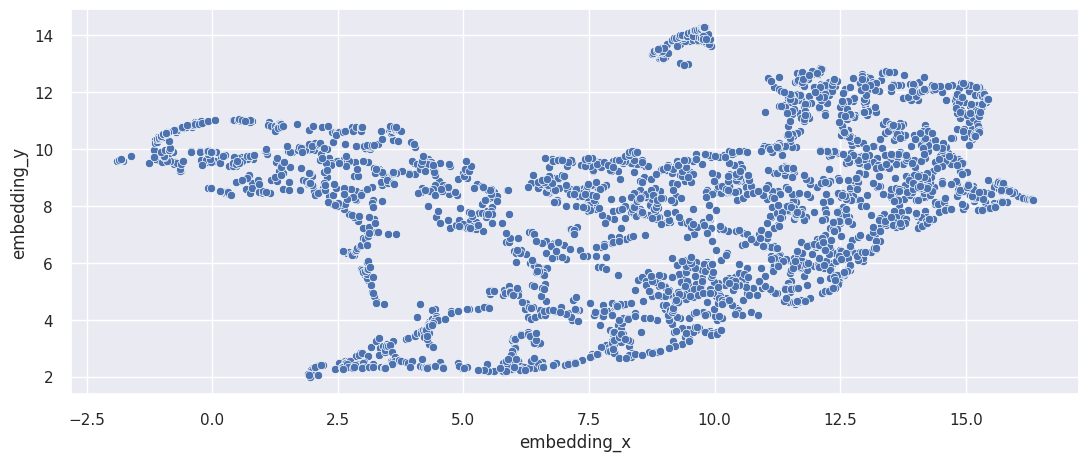

In [71]:
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_space)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

### 6.2.3 - T-SNE ANALYSIS

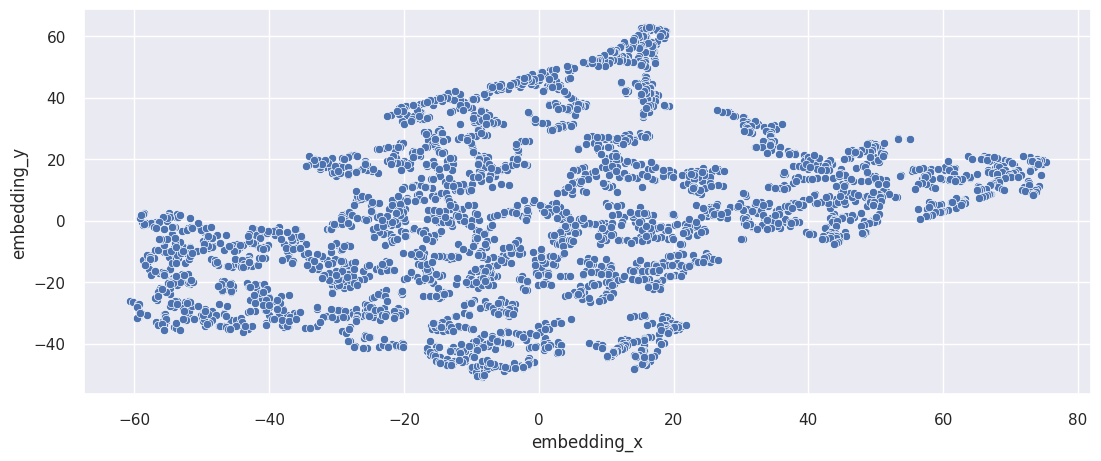

In [72]:
reducer = TSNE(random_state = 42, n_components = 2, n_jobs = -1, )
embedding = reducer.fit_transform(df_space)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

### 6.2.4 - TREE-BASED EMBEDDING ANALYSIS

In [73]:
#dataset split
x_train = df6.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y_train = df6['gross_revenue']

#model definition
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)

#model training
rf_model.fit(x_train, y_train)

#leaf
leaf = rf_model.apply(x_train)

#dataframe leaf
df_leaf = pd.DataFrame(leaf)
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3668,3661,3712,3701,3582,3565,3711,3424,3790,3699,...,3405,3683,3750,3576,3629,3696,3452,3748,3543,3543
1,2709,2985,2838,3187,3304,3151,3065,2896,3278,3170,...,3021,2075,3123,3002,2995,3198,3193,3034,3225,3266
2,3754,3740,3629,3584,3738,3796,3657,3745,3762,3622,...,3737,3634,3695,3672,3760,3595,3713,3665,3756,3828
3,2213,1782,2455,1653,1946,2070,1858,2553,1954,2167,...,2631,1878,1837,1820,2461,1568,1758,1876,1749,1806
4,935,114,1106,496,189,676,514,236,843,825,...,812,828,522,61,868,538,508,502,132,603


/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


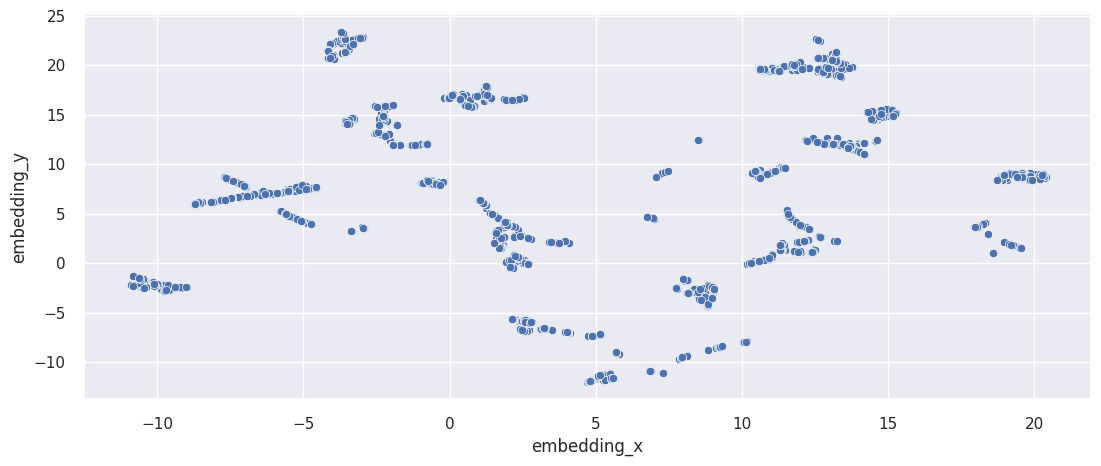

In [74]:
#Reduce of dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

# 7.0 - DATA PREPARATION

In [75]:
df7 = df6.copy()


## 7.1 - RESCALING

In [76]:
mms = MinMaxScaler()

df7['gross_revenue']            = mms.fit_transform(df7[['gross_revenue']])
df7['recency_days']             = mms.fit_transform(df7[['recency_days']])
df7['quantity_invoices']        = mms.fit_transform(df7[['quantity_invoices']])
df7['quantity_items']           = mms.fit_transform(df7[['quantity_items']])
df7['quantity_stock_code']      = mms.fit_transform(df7[['quantity_stock_code']])
df7['avg_ticket']               = mms.fit_transform(df7[['avg_ticket']])
df7['avg_recency_days']         = mms.fit_transform(df7[['avg_recency_days']])
df7['frequency']                = mms.fit_transform(df7[['frequency']])
df7['returns']                  = mms.fit_transform(df7[['returns']])
df7['avg_unique_basket_size']   = mms.fit_transform(df7[['avg_unique_basket_size']])
df7['avg_basket_size']          = mms.fit_transform(df7[['avg_basket_size']])

# 8.0 - HYPERPARAMETER FINE-TUNNING

In [91]:
parameter_tunning = df7.drop(columns = ['customer_id'])

In [92]:
cluster = list(range(2,8))

## 8.1 - K-MEANS

In [93]:
kmeans_list = []
for k in cluster:
    #model definition
    kmeans = KMeans(n_clusters = k)

    #model traning
    kmeans.fit(parameter_tunning)

    #validation
    labels = kmeans.predict(parameter_tunning)

    #performance
    sil = silhouette_score(parameter_tunning, labels, metric = 'euclidean')
    kmeans_list.append(sil)

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/

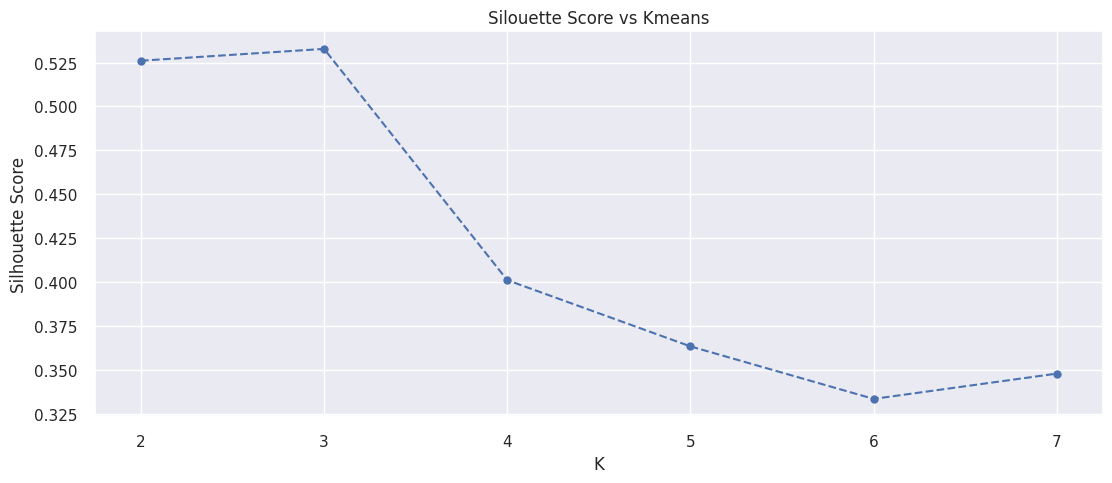

In [94]:
plt.plot(cluster, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Kmeans')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 


## 8.2 - GAUSSIAN MIXTURE MODEL (GMM)

In [95]:
gmm_list = []
for k in cluster:
    #model definition
    gmm = GaussianMixture(n_components= k)

    #model traning
    gmm.fit(parameter_tunning)

    #validation
    labels = gmm.predict(parameter_tunning)

    #performance
    sil = silhouette_score(parameter_tunning, labels, metric = 'euclidean')
    gmm_list.append(sil)

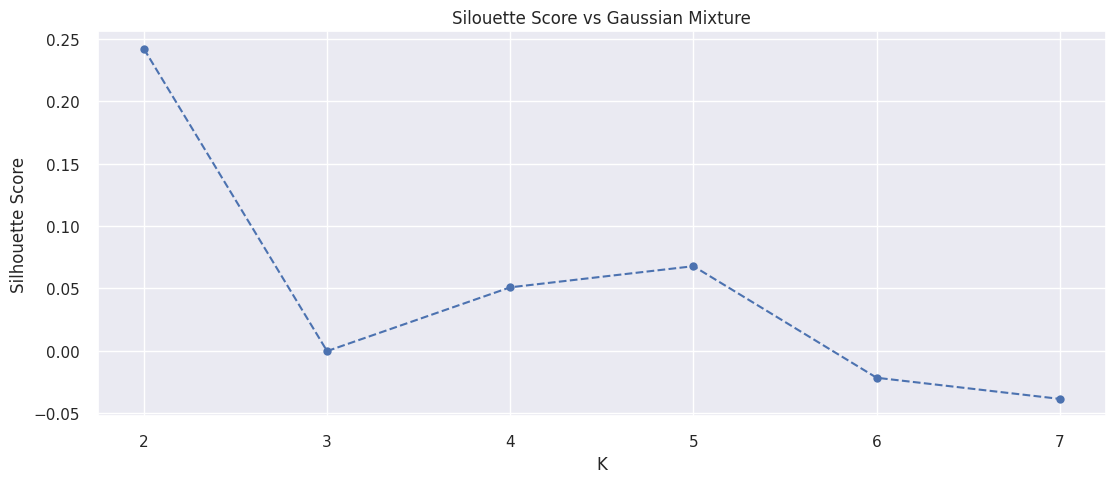

In [96]:
plt.plot(cluster, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Gaussian Mixture')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 

## 8.3 - HIERARCHICAL CLUSTERING

In [99]:
#Definition and training model
hc_model = linkage(parameter_tunning, 'ward')

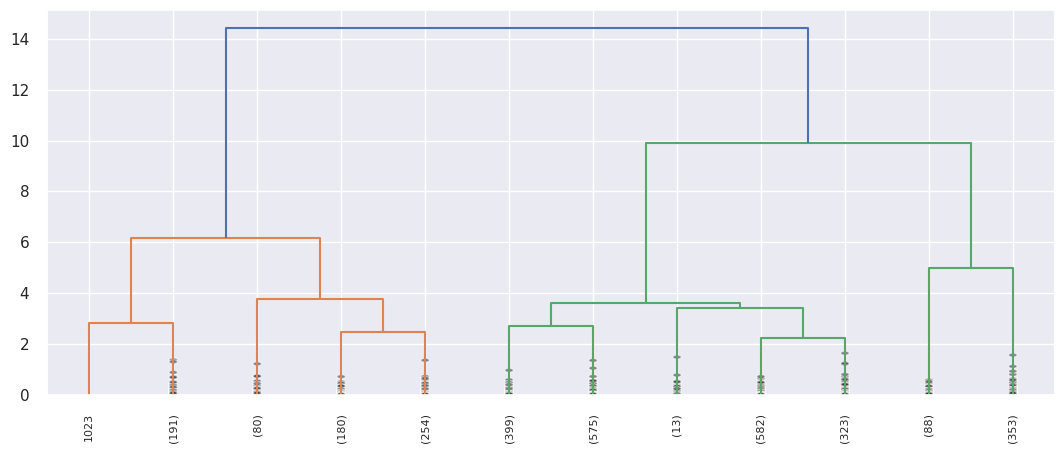

In [104]:
#plot
dendrogram(hc_model, leaf_rotation = 90, leaf_font_size = 8, truncate_mode='lastp', p = 12, show_contracted=True)
plt.show()


### 8.3.1 - HIERARCHICAL CLUSTERING SILHOUETTE SCORE

In [107]:
hc_list = []
for k in cluster:
    #model definition
    hc_model = linkage(parameter_tunning, 'ward')

    #model predict
    labels = fcluster(hc_model, k, criterion = 'maxclust')

    #performance
    sil = silhouette_score(parameter_tunning, labels, metric = 'euclidean')

    hc_list.append(sil)

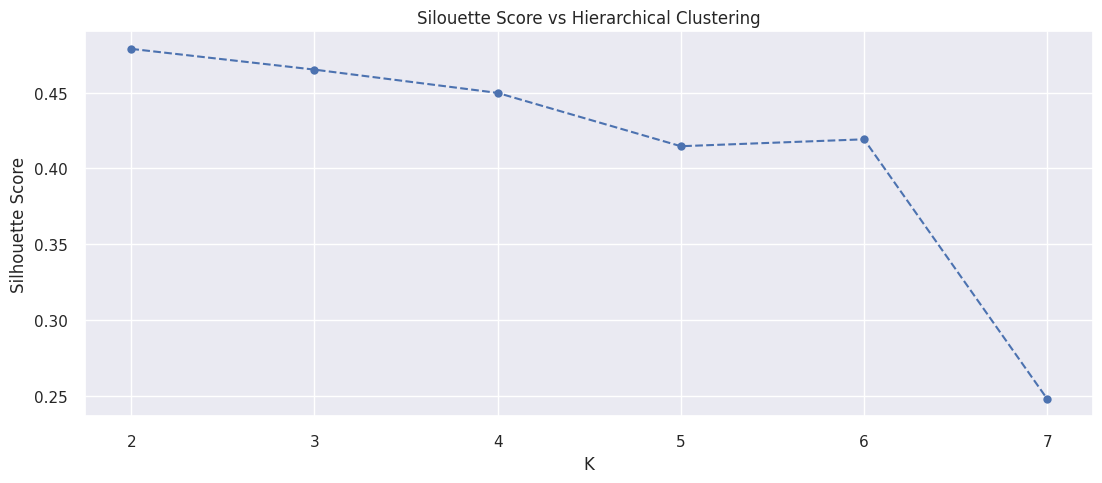

In [109]:
plt.plot(cluster, hc_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Hierarchical Clustering')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 

## 8.4 - DBSCAN

In [128]:
#Model definition
dbscan = DBSCAN(eps = 0.3, min_samples = 20)

#model training
labels = dbscan.fit_predict(parameter_tunning)

#performance

sil = silhouette_score(parameter_tunning, labels, metric = 'euclidean')
print('Silhouette Score: {}'.format(sil))
print(' Number of Clusters: {}'.format(len(np.unique(labels))))



Silhouette Score: 0.7036052273263511
 Number of Clusters: 2


In [129]:
dbscan_list = [0.6288413264190846, 0.7036052273263511, 0.7318813491682605, 0.7546427923574051, 0.7882920458663134, 0.7882920458663139]

## 8.5 - RESULTS OF PERFORMANCE

In [130]:
df_results = pd.DataFrame({'Kmeans': kmeans_list, 'Gaussian Mixture Model': gmm_list, 'Hierarchical Clustering': hc_list, 'DBSCAN': dbscan_list}).T
df_results.columns = cluster
df_results.style.highlight_max(color='darkgreen', axis = 1)

,2,3,4,5,6,7
Kmeans,0.526052,0.532780,0.401148,0.363462,0.333583,0.347970
Gaussian Mixture Model,0.242048,-0.000341,0.050821,0.067766,-0.021714,-0.038665
Hierarchical Clustering,0.478824,0.465147,0.449789,0.414621,0.419179,0.247948
DBSCAN,0.628841,0.703605,0.731881,0.754643,0.788292,0.788292


# 9.0 - MACHINE LEARNING MODEL

## 9.1 - K-MEANS

In [ ]:
#model definition
k = 5
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

#model training
kmeans.fit(parameter_tunning)

#clustering
labels = kmeans.labels_

## 9.2 - CLUSTER PERFOMANCE

In [ ]:
print('WSS Value: {}'.format(kmeans.inertia_))
print('Silhouette Score Value: {}'.format(silhouette_score(parameter_tunning, labels, metric = 'euclidean')))

WSS Value: 71.03954297822555
Silhouette Score Value: 0.3634623356111958


# 10.0 - CLUSTER ANALYSIS

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head(10)

,customer_id,gross_revenue,recency_days,quantity_invoices,quantity_items,quantity_stock_code,avg_ticket,avg_recency_days,frequency,returns,avg_unique_basket_size,avg_basket_size,cluster
0,17850,5391.21,371.0,34.0,35.0,21.0,18.152222,3.090909,17.000000,40.0,8.74,50.97,4
1,13047,3232.59,56.0,9.0,131.0,105.0,18.904035,23.928571,0.028302,35.0,19.00,154.44,0
2,12583,6705.38,2.0,15.0,1568.0,114.0,28.902500,23.750000,0.040431,50.0,15.47,335.20,0
3,13748,948.25,95.0,5.0,169.0,24.0,33.866071,93.333333,0.017921,0.0,5.60,87.80,3
4,15100,876.00,333.0,3.0,48.0,1.0,292.000000,9.200000,0.073171,22.0,1.00,26.67,4
5,15291,4623.30,25.0,14.0,508.0,61.0,45.326471,19.888889,0.040115,29.0,7.29,150.14,0
6,14688,5630.87,7.0,21.0,579.0,148.0,17.219786,14.730769,0.057221,399.0,15.57,172.43,0
7,17809,5411.91,15.0,12.0,961.0,46.0,88.719836,28.153846,0.033520,41.0,5.08,171.42,0
8,15311,60767.90,0.0,91.0,2167.0,567.0,25.543464,3.726496,0.243316,474.0,26.14,419.71,0
9,16098,2005.63,87.0,7.0,240.0,34.0,29.934776,41.285714,0.027875,0.0,9.57,87.57,1


## 10.1 - VISUALIZATION INSPECTION

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


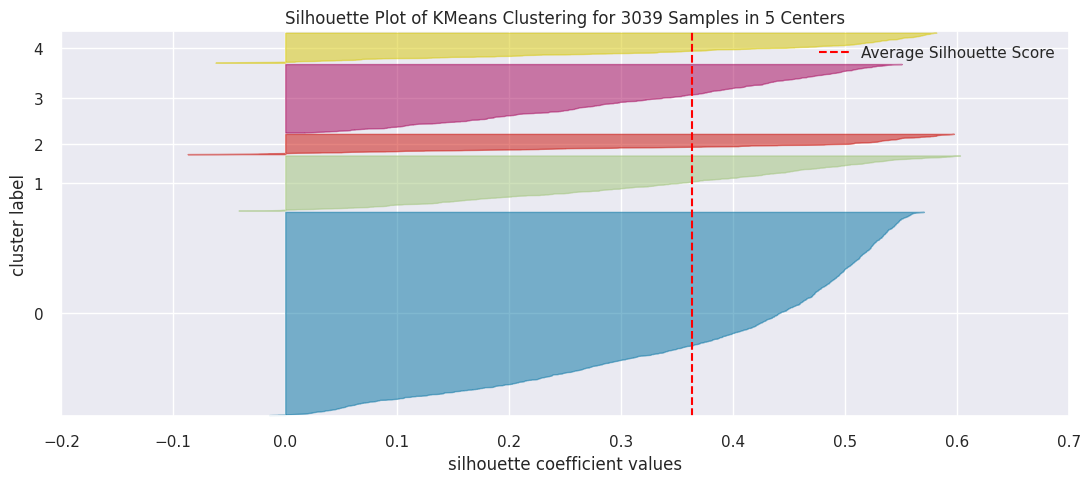

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(parameter_tunning)
visualizer.finalize()

## 10.2 - 2D PLOT

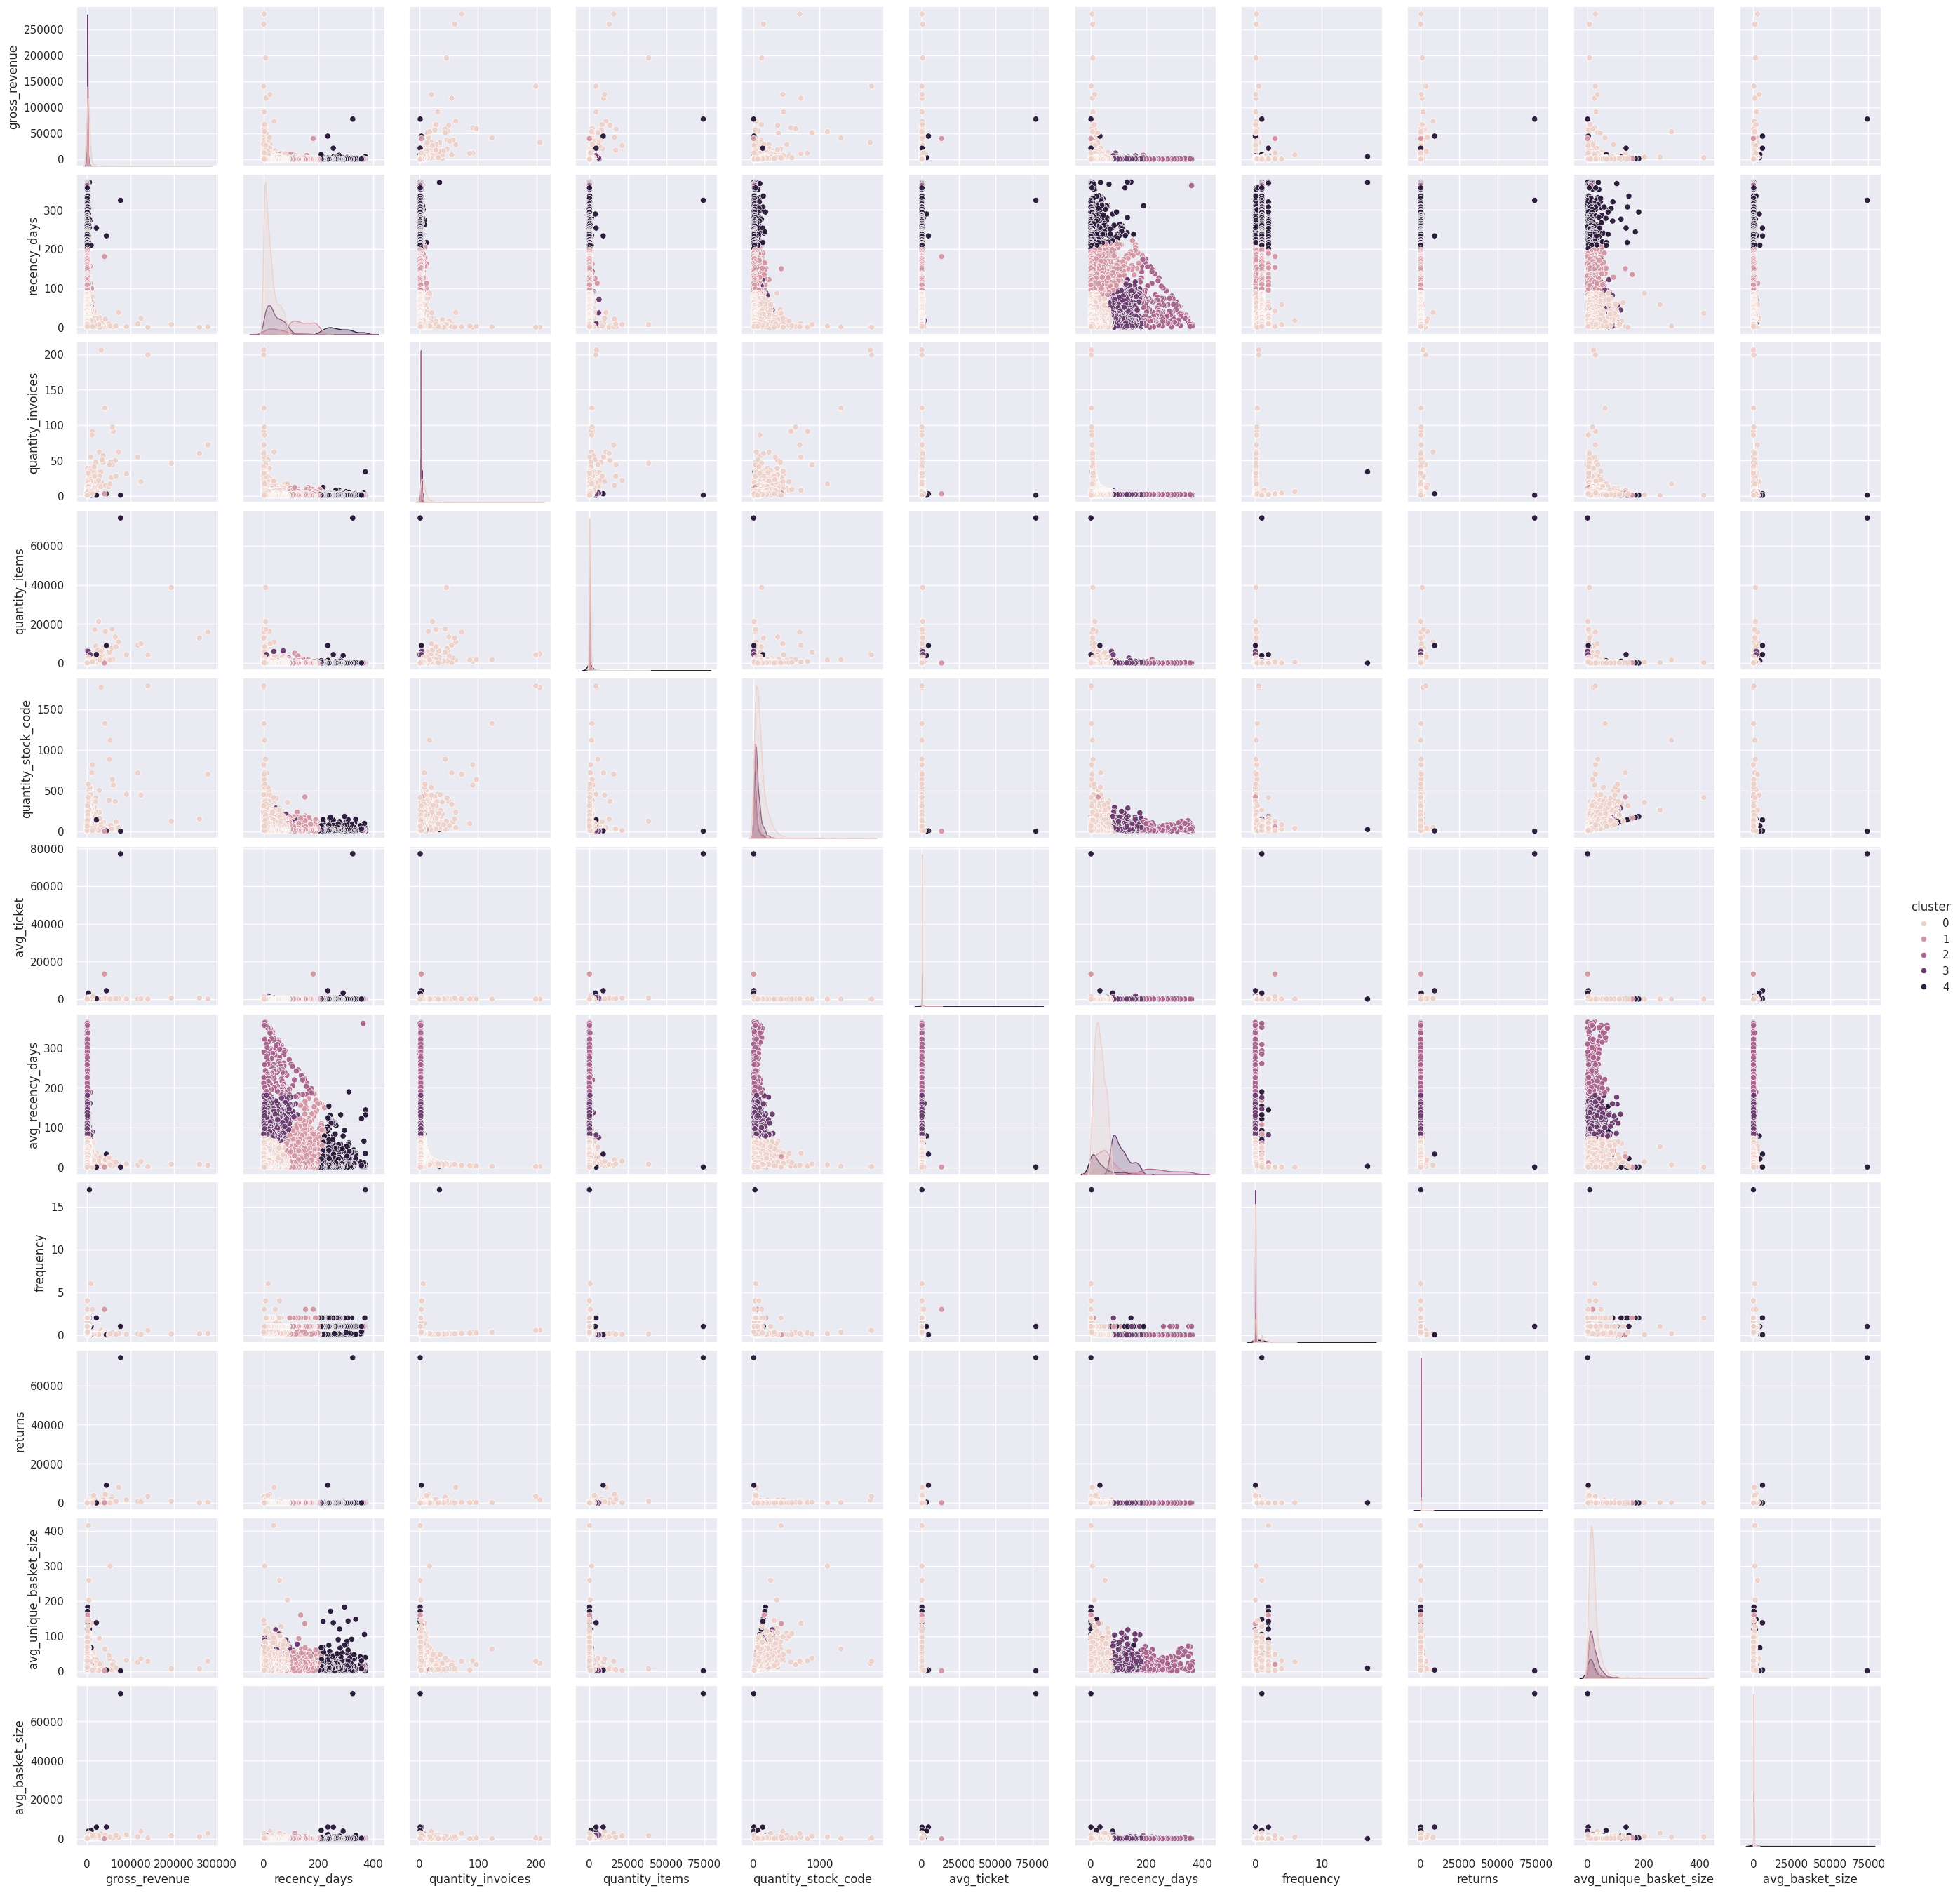

In [ ]:
df_viz = df9.drop(columns = 'customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster')
plt.show()

## 10.3 - UMAP - HIGH DIMENSIONALITY

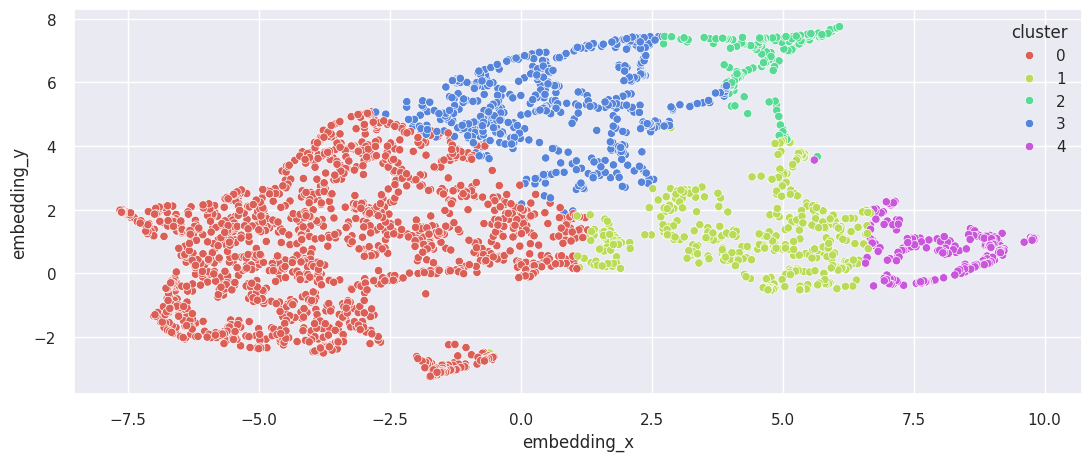

In [ ]:
reducer = umap.UMAP(random_state = 42, n_neighbors = 20, n_jobs = 1)
embedding = reducer.fit_transform(parameter_tunning)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_viz, x = 'embedding_x', y = 'embedding_y', 
                hue = 'cluster', 
                palette = sns.color_palette( 'hls', n_colors = len(df_viz['cluster'].unique())))

plt.show()

## 10.4 - CLUSTER PROFILE

In [ ]:
df9.sample(5)

,customer_id,gross_revenue,recency_days,quantity_invoices,quantity_items,quantity_stock_code,avg_ticket,avg_recency_days,frequency,returns,avg_unique_basket_size,avg_basket_size,cluster
587,16717,3858.38,23.0,6.0,293.0,176.0,19.388844,45.125,0.017493,298.0,33.17,311.00,0
2062,15712,1072.36,8.0,5.0,163.0,41.0,20.233208,70.250,0.017921,0.0,10.60,97.20,0
1307,14114,386.53,273.0,2.0,37.0,15.0,25.768667,57.000,0.035088,0.0,7.50,50.50,4
3741,14808,2741.17,39.0,8.0,731.0,176.0,11.664553,11.750,0.060150,92.0,29.38,268.38,0
5305,16347,887.65,10.0,2.0,145.0,61.0,9.648370,26.000,0.076923,0.0,46.00,176.50,0


In [ ]:
# Percentual of customers of each cluster
df_cluster = df9[['customer_id','cluster']].groupby('cluster')['customer_id'].count().reset_index().rename(columns = {'customer_id': 'total_customer'})
df_cluster['percentual_customer'] = (df_cluster['total_customer'] / df_cluster['total_customer'].sum()) * 100

#avg gross revenue
df_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster')['gross_revenue'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, on = 'cluster', how = 'inner')

#avg recency_days
df_recency_days = df9[['cluster', 'recency_days']].groupby('cluster')['recency_days'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days , on = 'cluster', how = 'inner')

#invoice number
df_invoice_no= df9[['cluster', 'quantity_invoices']].groupby('cluster')['quantity_invoices'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, on = 'cluster', how = 'inner')

#avg ticket
df_avg_ticket= df9[['cluster', 'avg_ticket']].groupby('cluster')['avg_ticket'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, on = 'cluster', how = 'inner')

df_cluster['percentual_customer'] = df_cluster['percentual_customer'].apply(lambda x: np.round(x, 2))
df_cluster['percentual_customer'] = df_cluster['percentual_customer'].astype(str)
df_cluster['percentual_customer'] = df_cluster['percentual_customer'].apply(lambda x: x + '%')
df_cluster['recency_days'] = df_cluster['recency_days'].astype(int)
df_cluster['quantity_invoices'] = df_cluster['quantity_invoices'].astype(int)

df_cluster['gross_revenue'] = df_cluster['gross_revenue'].apply(lambda x: "${:,.2f}".format(x))
df_cluster['avg_ticket'] = df_cluster['avg_ticket'].apply(lambda x: "${:,.2f}".format(x))

new_order_comuns = ['total_customer', 'cluster', 'percentual_customer', 'recency_days', 'quantity_invoices', 'gross_revenue', 'avg_ticket']
df_cluster = df_cluster[new_order_comuns]

df_cluster

,total_customer,cluster,percentual_customer,recency_days,quantity_invoices,gross_revenue,avg_ticket
0,1637,0,53.87%,23,8,"$4,075.28",$30.13
1,444,1,14.61%,145,3,"$1,090.16",$60.22
2,164,2,5.4%,54,1,$591.60,$26.15
3,552,3,18.16%,38,3,"$1,104.38",$29.27
4,242,4,7.96%,275,2,"$1,350.54",$389.54


CLUSTER 01: (Program Candidate High Value Customer)
 - Total of customers: 6 (0.14% of customers)
 - Average of Recency Days: 6
 - Average of invoice number: 89
 - Average of Gross Revenue: $182.181,98
 - Average of Average Ticket: $253.63

 CLUSTER 02:
 - Total of customers: 28 (0.64% of customers)
 - Average of Recency Days: 5
 - Average of invoice number: 57
 - Average of Gross Revenue: $42,614.39
 - Average of Average Ticket: $162.86

 CLUSTER 03:
 - Total of customers: 4071 (93.12% of customers)
 - Average of Recency Days: 96
 - Average of invoice number: 3
 - Average of Grossa Revenue: $946.70
 - Average of Average Ticket: $25.36

CLUSTER 04:
 - Total of customers: 267 (6.11% of customers)
 - Average of Recency Days: 19
 - Average of invoice number: 19
 - Average of Gross Revenue: $8,089.03
 - Average of Average Ticket: $62.78
